In this project, several supervised algorithms are used to accurately model individuals' income using data collected from the 1994 U.S. Census. The best candidate algorithm from preliminary results is picked and further optimized to best model the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features. 
The dataset for this project originates from the UCI Machine Learning Repository. The datset was donated by Ron Kohavi and Barry Becker, after being published in the article "Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid".

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

%matplotlib inline

data = pd.read_csv('census.csv')
data.head(2)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K


In [2]:
# Total number of records
n_records = data['income'].count() 

# Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == '>50K']['income'].count()

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == '<=50K']['income'].count()

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records *100

print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


In [3]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


# Preprocessing & EDA

Check the correlation for data points where the income is <= 50k

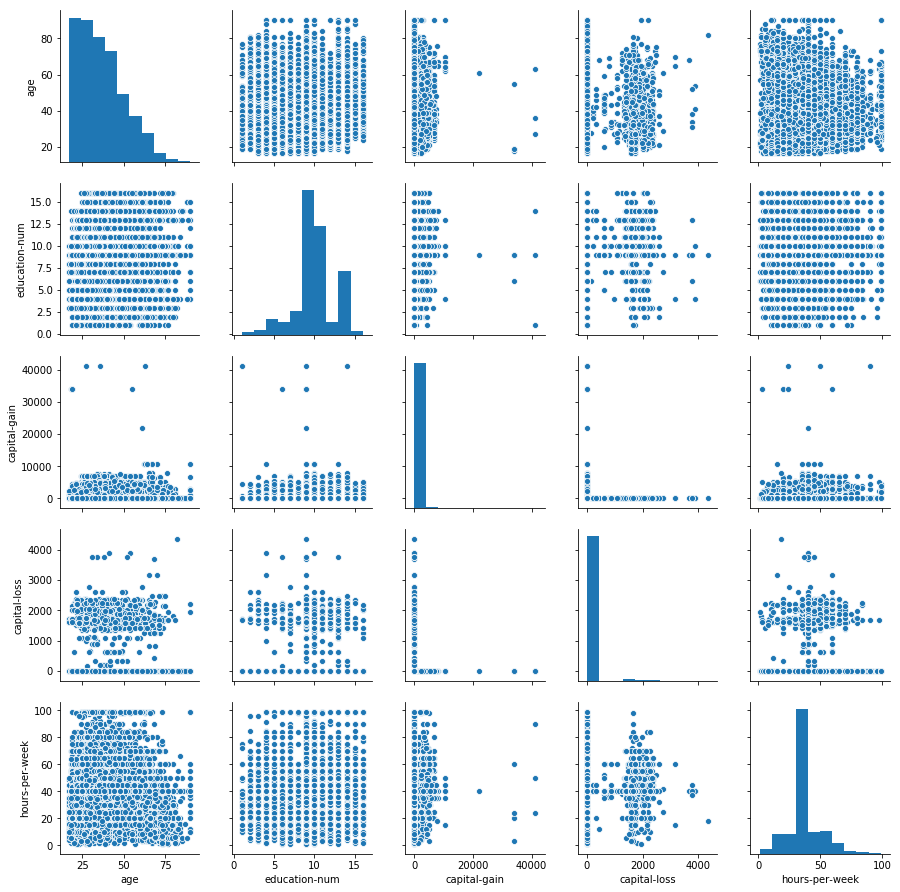

In [5]:
data_less_than_50k = data[data['income'] == '<=50K']
sns.pairplot(data_less_than_50k)

Check the correlation for data points where the income is > 50k

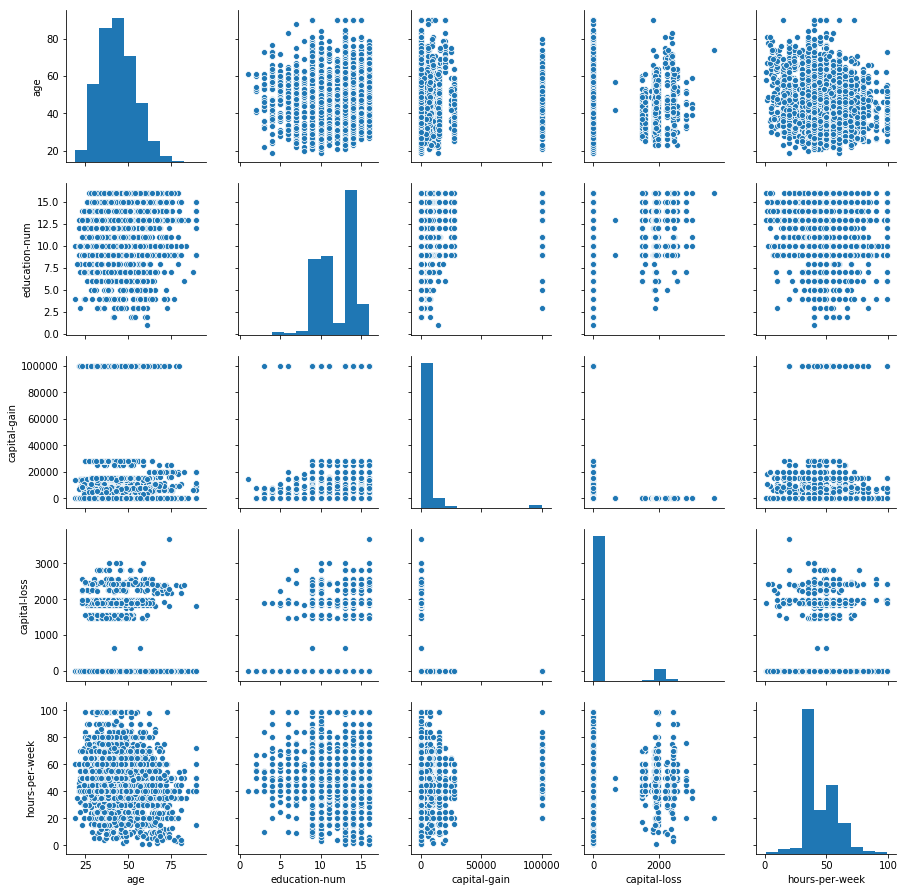

In [6]:
data_more_than_50k = data[data['income'] == '>50K']
sns.pairplot(data_more_than_50k)

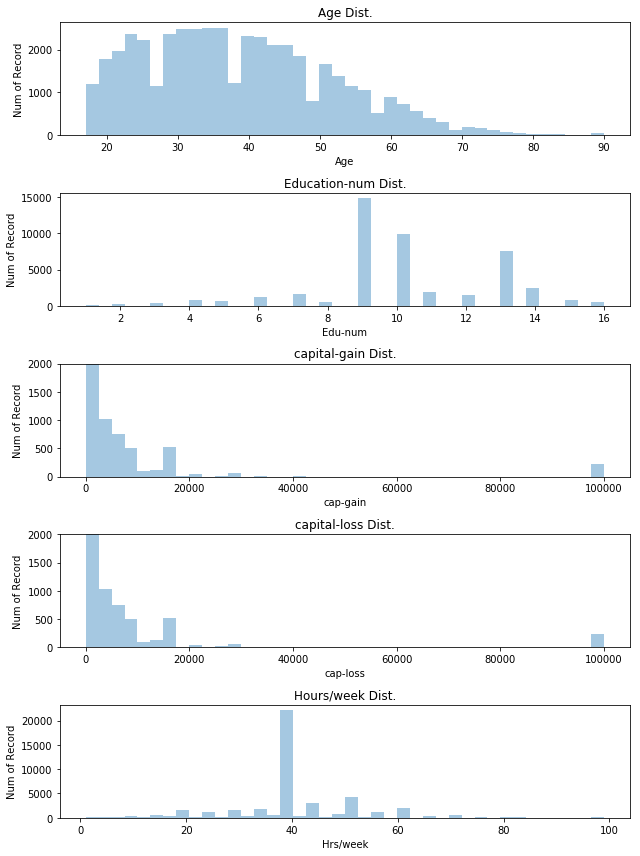

In [7]:
# Creating distribution plots of numerical variables to check the distribution and skewness of data

fig, axis = plt.subplots(5,1) 
fig.set_size_inches(9,12)

sns.distplot(data['age'], bins = 40, kde = False, ax = axis[0])
axis[0].set_ylabel('Num of Record')
axis[0].set_xlabel('Age')
axis[0].set_title('Age Dist.')

sns.distplot(data['education-num'], bins = 40, kde = False, ax = axis[1])
axis[1].set_ylabel('Num of Record')
axis[1].set_xlabel('Edu-num')
axis[1].set_title('Education-num Dist.')

sns.distplot(data['capital-gain'], bins = 40, kde = False, ax = axis[2])
axis[2].set_ylabel('Num of Record')
axis[2].set_xlabel('cap-gain')
axis[2].set_title('capital-gain Dist.')
axis[2].set_ylim(0,2000)

sns.distplot(data['capital-gain'], bins = 40, kde = False, ax = axis[3])
axis[3].set_ylabel('Num of Record')
axis[3].set_xlabel('cap-loss')
axis[3].set_title('capital-loss Dist.')
axis[3].set_ylim(0,2000)

sns.distplot(data['hours-per-week'], bins = 40, kde = False, ax = axis[4])
axis[4].set_ylabel('Num of Record')
axis[4].set_xlabel('Hrs/week')
axis[4].set_title('Hours/week Dist.')
#axis[3].set_ylim(0,2000)

fig.tight_layout()

Log Transformation of Skewed Features

In [8]:
#Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

skewed_data = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)

#The logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully
features_log_transformed[skewed_data] = features_raw[skewed_data].apply(lambda x:np.log(x+1))

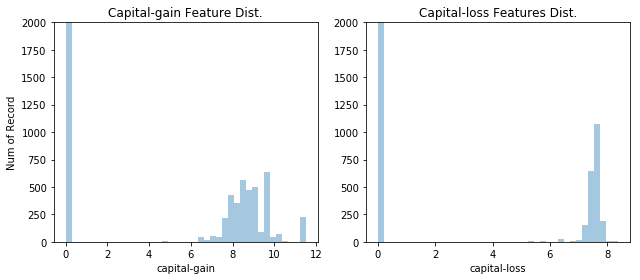

In [9]:
# Creating the distribution plots of the log transformation

fig_transformed, axis = plt.subplots(1,2)
fig_transformed.set_size_inches(9,4)

sns.distplot(features_log_transformed[skewed_data]['capital-gain'], bins =40, kde = False, ax = axis[0])
axis[0].set_ylabel('Num of Record')
axis[0].set_ylim(0,2000)
axis[0].set_title('Capital-gain Feature Dist.')

sns.distplot(features_log_transformed[skewed_data]['capital-loss'], bins =40, kde = False, ax = axis[1])
axis[1].set_ylim(0,2000)
axis[1].set_title('Capital-loss Features Dist.')

fig_transformed.tight_layout()

Normalizing Numerical Features

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initiate the scaler then applying to the features
scaler = MinMaxScaler()
numerical_feat = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_log_mms_transform = pd.DataFrame(data = features_log_transformed) 
features_log_mms_transform[numerical_feat] = scaler.fit_transform(features_log_transformed[numerical_feat])

features_log_mms_transform.head(4)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States


Implementing Preprocessing and Converting Categorical Features to Numerical

In [11]:
# One-hot encode the 'features_log_mms_transform' data using pandas.get_dummies()
final_features = pd.get_dummies(features_log_mms_transform)

# Endcoe the 'income_raw' to numerical values
income = income_raw.apply(lambda x:1 if x == '>50K' else 0)

# Number of features after one-hot encoding
num_final_features = list(final_features.columns)
print('Total features after encoding is {}'.format(len(num_final_features)))


Total features after encoding is 103


# Split the data 

In [21]:
from sklearn.model_selection import train_test_split

# Split the 'final_features' and 'income' data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(final_features, income, 
                                                    test_size = 0.2, random_state = 24 )

# Check the split results
print('Training set has {} samples'.format(len(X_train)))
print('Testing set has {} samples'.format(len(X_test)))

Training set has 36177 samples
Testing set has 9045 samples


# Evaluating the model performace with Naive Predictor as a Benchmark

Generating a naive predictor is simply to show what a base model without any intelligence look like. 
ex: When we have a model that always predicts '1'

In [22]:
accuracy = sum(income)/len(income)
recall = sum(income)/sum(income)
precision = sum(income)/ (income.count())
f_score = 2*precision*recall / (precision + recall)
print ('Naive Predictor: [Accuracy: {:.4f}, recall: {:.4f}, precision: {:.4f}, f_score: {:.4f}'.format(accuracy, recall, precision, f_score))

Naive Predictor: [Accuracy: 0.2478, recall: 1.0000, precision: 0.2478, f_score: 0.3972


# Supervised Learning Models

In [38]:
# Creating a Training and Predicting Pipeline: to quickly and effectively 
# train models using various sizes of training data and perform predictions on the testing data

from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

def predict_func(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    results = {}

    start = time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    results['train_time'] = end - start  
    
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time()
    
    results['pred_time'] = end - start
    
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
    
    results['precision_train'] = precision_score(y_train[:300], predictions_train)
    results['precision_test'] = precision_score(y_test, predictions_test)
    
    results['recall_train'] = recall_score(y_train[:300], predictions_train)
    results['recall_test'] = recall_score(y_test, predictions_test)
    
    results['roc_auc_train'] = roc_auc_score(y_train[:300], predictions_train)
    results['roc_auc_test'] = roc_auc_score(y_test, predictions_test)
    
    print('{} trained on {} sample'.format(learner.__class__.__name__, sample_size))
    
    print('Classification report on test predictions''\n''{}'.format(classification_report(y_test,predictions_test)))
    print('ROC AUC score on test predictions:{:.4f}'.format(roc_auc_score(y_test,predictions_test)))
    print('\n')
    
#    print('Classification report on train predictions''\n''{}'.format(classification_report(y_train[:300], predictions_train)))
#    print('\n')
       
#    print('Confusion matrix on test predictions {}'.format(confusion_matrix(y_test, predictions_test)))
#    print('Confusion matrix on test predictions {}'.format(confusion_matrix(y_train[:300], predictions_train))    
   
    return results 
    

Implementing the Models

In [27]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

clf_A = AdaBoostClassifier(random_state=24)
clf_B = RandomForestClassifier(random_state=24)
clf_C = DecisionTreeClassifier(random_state=24)
clf_D = SVC(random_state=24)
clf_E = LogisticRegression(random_state=24)

samples_100 = len(X_train)
samples_10 = int(len(X_train)/10)
samples_1 = int(len(X_train)/100)

results= {}
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate ([samples_1, samples_10, samples_100]):
        results[clf_name][i] = predict_func(clf, samples, X_train, y_train, X_test, y_test)
                    

AdaBoostClassifier trained on 361 sample
Classification report on test predictions
             precision    recall  f1-score   support

          0       0.87      0.88      0.88      6766
          1       0.63      0.62      0.63      2279

avg / total       0.81      0.81      0.81      9045

ROC AUC score on test predictions:0.7490


AdaBoostClassifier trained on 3617 sample
Classification report on test predictions
             precision    recall  f1-score   support

          0       0.88      0.92      0.90      6766
          1       0.73      0.62      0.67      2279

avg / total       0.84      0.85      0.84      9045

ROC AUC score on test predictions:0.7714


AdaBoostClassifier trained on 36177 sample
Classification report on test predictions
             precision    recall  f1-score   support

          0       0.87      0.94      0.91      6766
          1       0.77      0.60      0.67      2279

avg / total       0.85      0.85      0.85      9045

ROC AUC score on 

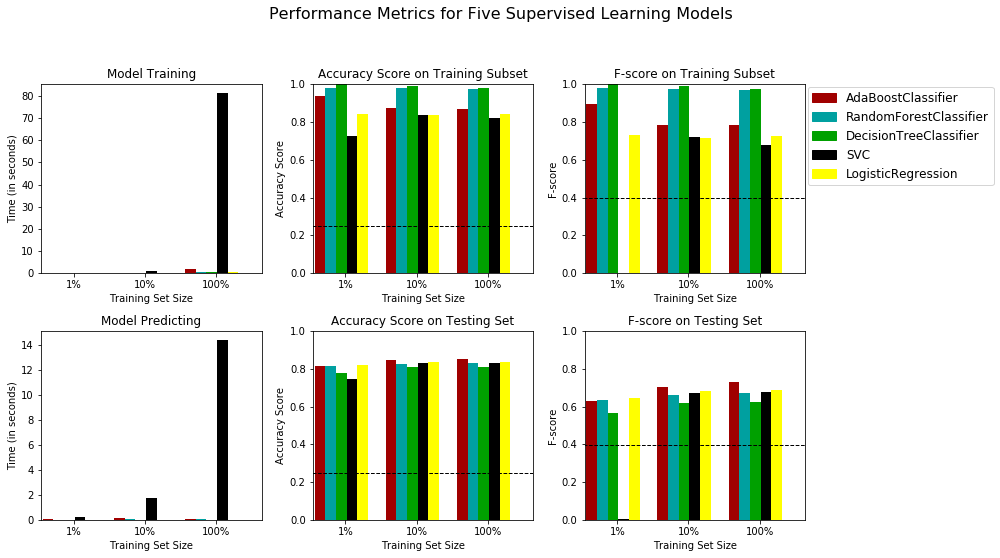

In [33]:
# Create plots to compare "time, accuracy, and f_score" of the 5 implemented classification models 

import matplotlib.patches as mpatches

fig, ax = plt.subplots(2, 3, figsize = (14,7))
# Constants
bar_width = .15
colors = ['#A00000','#00A0A0','#00A000', 'k', 'yellow']
# Super loop to plot four panels of data
for k, learner in enumerate(results.keys()):
    for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
        for i in np.arange(3):
            
            # Plot code
            ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
            ax[j//3, j%3].set_xticks([0.36, 1.36, 2.36])
            ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
            ax[j//3, j%3].set_xlabel("Training Set Size")
            ax[j//3, j%3].set_xlim((-0.1, 3.0))
    

# Add unique y-labels
ax[0, 0].set_ylabel("Time (in seconds)")
ax[0, 1].set_ylabel("Accuracy Score")
ax[0, 2].set_ylabel("F-score")
ax[1, 0].set_ylabel("Time (in seconds)")
ax[1, 1].set_ylabel("Accuracy Score")
ax[1, 2].set_ylabel("F-score")
    
# Add titles
ax[0, 0].set_title("Model Training")
ax[0, 1].set_title("Accuracy Score on Training Subset")
ax[0, 2].set_title("F-score on Training Subset")
ax[1, 0].set_title("Model Predicting")
ax[1, 1].set_title("Accuracy Score on Testing Set")
ax[1, 2].set_title("F-score on Testing Set")
 
# Add horizontal lines for naive predictors
ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[0, 2].axhline(y = f_score, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1, 2].axhline(y = f_score, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
# Set y-limits for score panels
ax[0, 1].set_ylim((0, 1))
ax[0, 2].set_ylim((0, 1))
ax[1, 1].set_ylim((0, 1))
ax[1, 2].set_ylim((0, 1))

# Create patches for the legend
patches = []
for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
ax[0,2].legend(handles = patches, bbox_to_anchor = (1,1), loc = 2, \
               borderaxespad = 0.2, ncol = 1, fontsize = 'large')
   
# Aesthetics
plt.suptitle("Performance Metrics for Five Supervised Learning Models", fontsize = 16, y = 1.10)
plt.tight_layout()
plt.show()

# Best Model Tuning

In [34]:
# Pick the AdaBoost model as the best candid model among the candidates and perform model tuning by using Grid search 

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = AdaBoostClassifier(random_state = 24)
parameters = {'n_estimators': [25,50,75,100,150], 'learning_rate': [1, 0.1, 0.01, 0.001, 0.0001]}

scorer = make_scorer(fbeta_score, beta = 0.5)

# Performing Grid Search
grid_obj = GridSearchCV(estimator = clf, param_grid = parameters, scoring = scorer)
grid_search_fit = grid_obj.fit(X_train, y_train)

# Get the best estimator
best_clf = grid_search_fit.best_estimator_

# predictions of unoptimized and optimized models
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

#Results
print('Unoptimized model\n------')
print('Accuracy score on testing data:{:.4f}'.format(accuracy_score(y_test, predictions)))
print('f_beta score on testing data:{:.4f}'.format(fbeta_score(y_test, predictions, beta = 0.5)))
print('\n')
print('Optimized model\n-------')
print('Accuracy score on testing data:{:.4f}'.format(accuracy_score(y_test,best_predictions)))
print('f_beta score on testing data:{:.4f}'.format(fbeta_score(y_test, best_predictions, beta = 0.5)))


Unoptimized model
------
Accuracy score on testing data:0.8534
f_beta score on testing data:0.7274


Optimized model
-------
Accuracy score on testing data:0.8599
f_beta score on testing data:0.7407


In [18]:
best_clf.get_params

<bound method BaseEstimator.get_params of AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=150, random_state=24)>

# Extracting Feature Importance

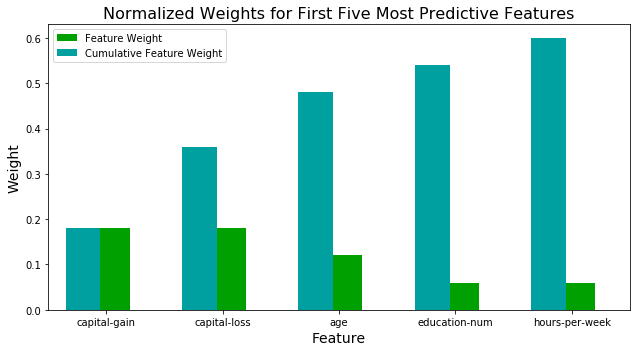

In [35]:
# Which features provide the most predictive power

model = AdaBoostClassifier()
model.fit(X_train, y_train)

important_feat = model.feature_importances_

# Display the five most important features
indices = np.argsort(important_feat)[::-1]
columns = X_train.columns.values[indices[:5]]
values = important_feat[indices][:5]

# Create the plot
fig_imp = plt.figure(figsize = (9,5))
plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
plt.bar(np.arange(5), values, width = 0.4, align="center", color = '#00A000', \
       label = "Feature Weight")
plt.bar(np.arange(5) - 0.2, np.cumsum(values), width = 0.3, align = "center", color = '#00A0A0', \
       label = "Cumulative Feature Weight")
plt.xticks(np.arange(5), columns)
plt.xlim((-0.5, 4.5))
plt.ylabel("Weight", fontsize = 14)
plt.xlabel("Feature", fontsize = 14)
   
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()  
